# NBA MVP Prediction Using Machine Learning
This notebook follows the same structure as `mvp_prediction.py`, loading data, preprocessing, training three models (Logistic Regression, Random Forest, XGBoost), evaluating them, plotting ROC curves, and running SHAP interpretability.

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, auc

import xgboost as xgb
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)

# Load player-season dataset
nba_df = pd.read_csv("data/NBA_Dataset.csv")
nba_df["player"] = nba_df["player"].str.strip()
nba_df["season"] = nba_df["season"].astype(int)

# Load MVP voting data
mvp_2001_2010 = pd.read_csv("data/2001-2010 MVP Data.csv")
mvp_2010_2021 = pd.read_csv("data/2010-2021 MVP Data.csv")
mvp_2022_2023 = pd.read_csv("data/2022-2023 MVP Data.csv")
mvp_all = pd.concat([mvp_2001_2010, mvp_2010_2021, mvp_2022_2023], ignore_index=True)
mvp_all["player"] = mvp_all["Player"].str.strip()
mvp_all["season"] = mvp_all["year"].astype(int)
mvp_all["Rank"] = pd.to_numeric(mvp_all["Rank"], errors="coerce")
mvp_all["label"] = mvp_all["Rank"].apply(lambda r: 1 if r == 1 else (2 if r <= 3 else (3 if r <= 10 else 0)))
mvp_labels = mvp_all[["season", "player", "label"]]

# Load RAPTOR data and merge
rap_h = pd.read_csv("data/historical_RAPTOR_by_player.csv")
rap_m = pd.read_csv("data/modern_RAPTOR_by_player.csv")
rap_cols = ["player_name", "season", "raptor_offense", "raptor_defense", "raptor_total"]
rap = pd.concat([rap_h[rap_cols], rap_m[rap_cols]], ignore_index=True)
rap = rap.drop_duplicates(subset=["player_name", "season"])
rap = rap.rename(columns={"player_name": "player"})

# Merge datasets
bb = nba_df.copy()
df = bb.merge(rap, on=["season", "player"], how="left").merge(mvp_labels, on=["season", "player"], how="left")
df["label"] = df["label"].fillna(0).astype(int)
df = df[(df["season"] >= 2001) & (df["season"] <= 2022) & (df["mp"] >= 1000)]
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

In [88]:
# Define features and label
features = [
    "ws", "bpm", "vorp", "pts_per_g", "ast_per_g", "trb_per_g",
    "usg_pct", "ts_pct", "raptor_total", "win_loss_pct"
]
X = df[features]
y = df["label"]


In [89]:
# Train/test split (time-aware)
train_df = df[df["season"] <= 2018]
test_df = df[df["season"] > 2018]
X_train = train_df[features]
y_train = train_df["label"]
X_test = test_df[features]
y_test = test_df["label"]

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1006
           1       0.50      0.50      0.50         4
           2       1.00      0.25      0.40         8
           3       0.56      0.19      0.28        27

    accuracy                           0.97      1045
   macro avg       0.76      0.48      0.54      1045
weighted avg       0.96      0.97      0.96      1045



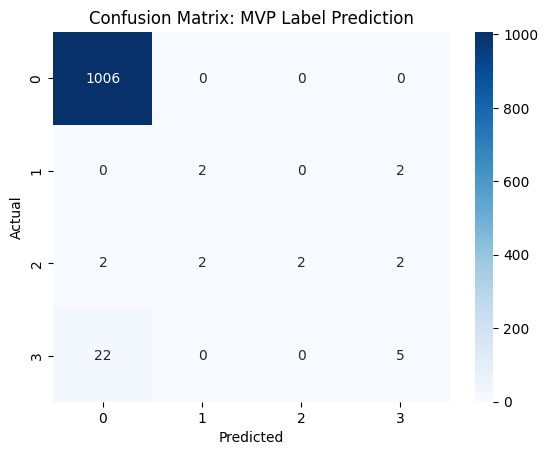

In [90]:
# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: MVP Label Prediction")
plt.show()


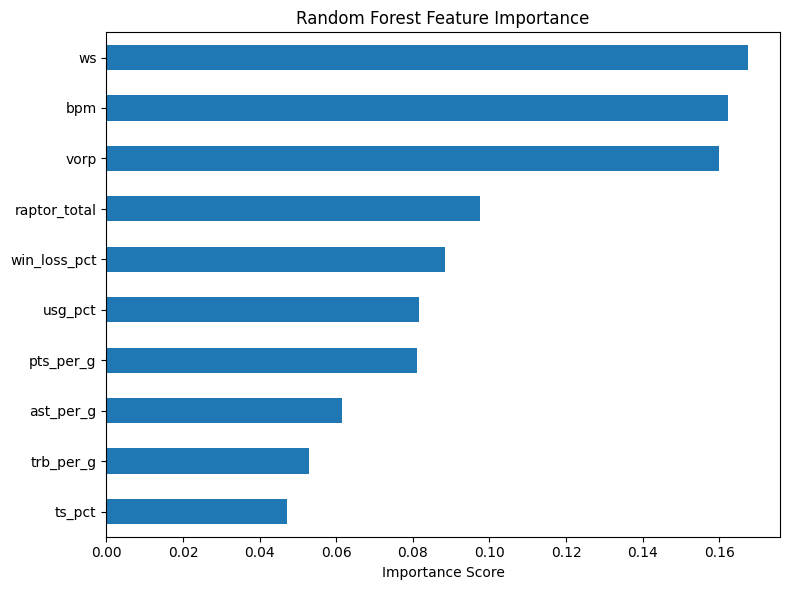

In [91]:
importances = clf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

# Plot it
plt.figure(figsize=(8, 6))
feat_imp.plot(kind="barh")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

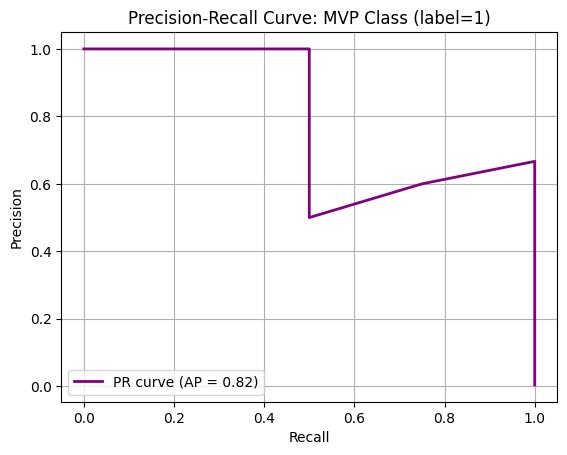

In [92]:
precision, recall, _ = precision_recall_curve((y_test == 1).astype(int), y_score[:, 1])
ap = average_precision_score((y_test == 1).astype(int), y_score[:, 1])

plt.figure()
plt.plot(recall, precision, color="purple", lw=2, label="PR curve (AP = %.2f)" % ap)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: MVP Class (label=1)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()